## Loading libraries and helper libraries  

In [27]:
import os
import sys
import warnings

import numpy as np
import pandas as pd

from mizani.formatters import percent_format
from mizani.transforms import log_trans
from mizani.formatters import log_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


## Loading, exploring, and manipulating data. 

In [28]:
# Loading data and checking
main_df = pd.read_csv('https://osf.io/4ay9x/download')
main_df.head().T

,0,1,2,3,4
Unnamed: 0,3,5,6,10,11
hhid,2600310997690,75680310997590,75680310997590,179140131100930,179140131100930
intmonth,January,January,January,January,January
stfips,AL,AL,AL,AL,AL
weight,3151.6801,3457.1138,3936.911,3288.364,3422.85
earnwke,1692.0,450.0,1090.0,769.23,826.92
uhours,40,40,60,40,40
grade92,43,41,41,40,43
race,1,2,2,1,1
ethnic,NaN,NaN,NaN,NaN,NaN


### Doing exploratory data analysis for filtering data to my needs


In [29]:
# Selected weekly earnings, weekly work hours, and age as they were the changing variables for each categories

main_df[['earnwke','uhours','age']].describe().round(2)

,earnwke,uhours,age
count,149316.00,149316.00,149316.00
mean,888.83,38.94,40.71
std,643.74,10.26,12.78
min,0.01,1.00,16.00
25%,430.00,40.00,30.00
50%,719.60,40.00,41.00
75%,1153.84,40.00,52.00
max,2884.61,99.00,64.00


Note that `earnwke (weekly earnings)` have a min of 0.01 <br>
Note that `uhours(weekly hours)` have a min of 1.00<br>
Note that `age` has a min of 16

I decided to check the gender wage gap for Chief Executives. Using the documentation I found out the codes for the Chief executives. I also filtered the data to suit it further to my analyses. <br>
`occ2012`: 10 (Chief Executives) <br>
`uhours > 20`: to make sure an indiviual worked atleast half a day in a week considering 5 workday weeks<br>
`age >= 17`: older than or of 17 years of age <br>
`age <= 64`: younger than or of 64 years of age <br> 
`earnwke > 0`: positive earnings


In [30]:
df = main_df.loc[(main_df['occ2012'] == 10) # Filtering for Chief Executives
                 & (main_df['uhours'] >= 20) # Filtering for at least 20 hours/week worked 
                 & (main_df['age'] >= 17) # Filtering for at least 17 years of age
                 & (main_df['age'] <= 64) # Filtering for at most 64 years of age
                 & (main_df['earnwke'] > 0) # Filtering for more than 0 wage
                 
                ]                     
df.shape

(1266, 23)

To filter even more for my analyses, I selected the individuals that have a `grade92(education level)` <br>
BETWEEN 41 (Associate degree - Vocational/occupational) AND 46 (Doctorate degree)

In [31]:
df = df[((df['grade92'] >= 41) & (df['grade92'] <= 46))]  
df.shape

(1044, 23)

Creating columns for female indicator, hourly wage, and log(hourly wage)

In [32]:
df['female'] = (df['sex'] == 2).astype(int)
df['wagehrly'] = df['earnwke'] / df['uhours']
df["lnwagehrly"] = np.log(df["wagehrly"])
df.head().T

,38,191,540,599,696
Unnamed: 0,80,435,1230,1344,1572
hhid,97973400095118,90947006014265,4003608069611,60901093001001,260018057903296
intmonth,January,January,January,January,January
stfips,AL,AK,CA,CA,CA
weight,3206.3662,332.7025,2996.9309,3716.5958,2985.998
earnwke,2000.0,1413.0,2750.0,1230.0,500.0
uhours,60,40,40,50,40
grade92,43,43,43,44,43
race,1,1,1,4,2
ethnic,NaN,NaN,NaN,NaN,NaN


## Selection of regression variable
`wagehrly`? or `ln wagehrly`?

In [33]:
# Figuring out which variable to use `wagehourly` or `lnw`(log of wagehourly) for regression
# Distribution comparison to see which is more normally spread out (close to normal distribution)

fig = make_subplots(rows=1, cols=2, subplot_titles=('wagehrly', 'lnwagehrly'))

fig.add_trace(go.Histogram(x=df['wagehrly'], 
                           marker=dict(color='lightblue',
                           line=dict(color='black',
                           width=0.15))),
                           row=1, col=1)


fig.add_trace(go.Histogram(x=df['lnwagehrly'], 
                           marker=dict(color='lightblue', 
                           line=dict(color='black', 
                           width=0.15))), 
                           row=1, col=2)


fig.update_layout(title_text='Distribution comparison', 
                  title_x = 0.5,
                  plot_bgcolor ='white',
                  showlegend=False)

fig.show()

### Level - Level Regression
Since `wagehrly` is closer to normal distribution than `lnwagehrly`, it makes sense that `wagehrly` is used for regression <br>
    1. 1st regression is run without statistical inference <br>
    2. 2nd regression is run statistical inference (Heteroskedastic robust SE)

In [34]:
reg1 = smf.ols(formula="wagehrly~female", data=df).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wagehrly   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     13.47
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           0.000255
Time:                        13:41:05   Log-Likelihood:                -4403.6
No. Observations:                1044   AIC:                             8811.
Df Residuals:                    1042   BIC:                             8821.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.8961      0.592     77.542      0.000      44.735      47.058
female        -4.2558      1.160     -3.670      0.000      -6.531      -1.980
==============================================================================
Omnibus:                       22.316   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.910
Skew:                          -0.129   Prob(JB):                     0.000954
Kurtosis:                       2.497   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
reg2 = smf.ols(formula="wagehrly~female", data=df).fit(cov_type="HC1") 
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wagehrly   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     11.99
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           0.000556
Time:                        13:41:06   Log-Likelihood:                -4403.6
No. Observations:                1044   AIC:                             8811.
Df Residuals:                    1042   BIC:                             8821.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.8961      0.572     80.278      0.000      44.776      47.017
female        -4.2558      1.229     -3.463      0.001      -6.664      -1.847
==============================================================================
Omnibus:                       22.316   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.910
Skew:                          -0.129   Prob(JB):                     0.000954
Kurtosis:                       2.497   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [36]:
stargazer = Stargazer([reg1, reg2])
stargazer.covariate_order(["female", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

## Adding education level columns
I only included 41 to 46 

In [37]:
df['AD_V'] = (df['grade92'] == 41).astype(int) # Associate degree (Vocational/occupational)
df['AD_AP'] = (df['grade92'] == 42).astype(int) # Associate degree (Academic Program)
df['BD'] = (df['grade92'] == 43).astype(int) # Bachelor's degree (e.g.BA,AB,BS)
df['MD'] = (df['grade92'] == 44).astype(int) # Master's degree (e.g.MA,MS,MEng,Med,MSW,MBA) 
df['PD'] = (df['grade92'] == 45).astype(int) # Professional degree (e.g.MD,DDS,DVM,LLB,JD)
df['PhD'] = (df['grade92'] == 46).astype(int) # Doctorate degree(e.g.PhD,EdD)

In [38]:
df.head().T

,38,191,540,599,696
Unnamed: 0,80,435,1230,1344,1572
hhid,97973400095118,90947006014265,4003608069611,60901093001001,260018057903296
intmonth,January,January,January,January,January
stfips,AL,AK,CA,CA,CA
weight,3206.3662,332.7025,2996.9309,3716.5958,2985.998
earnwke,2000.0,1413.0,2750.0,1230.0,500.0
uhours,60,40,40,50,40
grade92,43,43,43,44,43
race,1,1,1,4,2
ethnic,NaN,NaN,NaN,NaN,NaN


## Non Parametric Regression
Graph of Hourly Wage ~ Education level

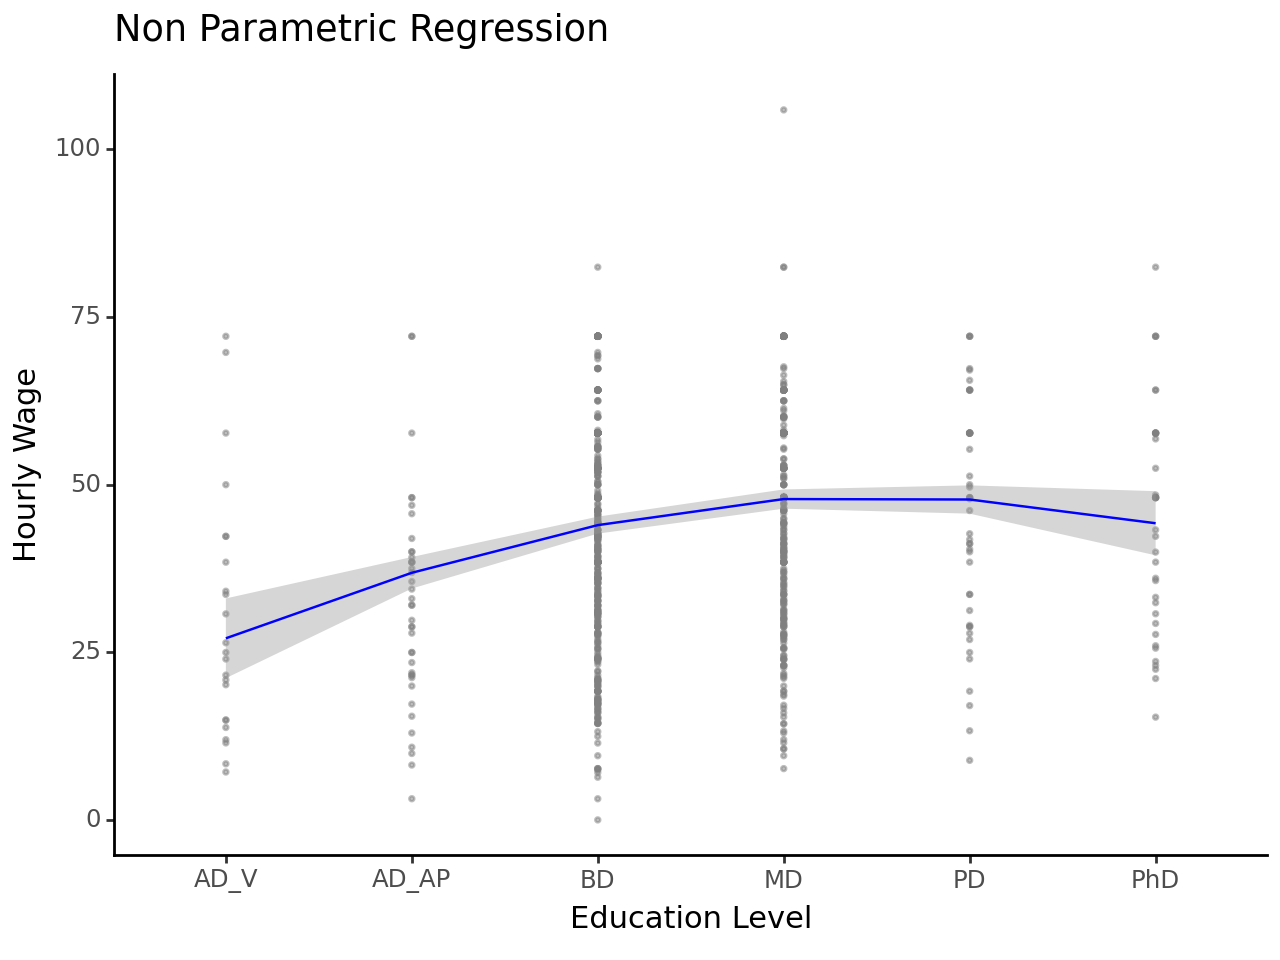

In [39]:
non_parametric_plot = (
                    ggplot(df, aes(x='grade92', y='wagehrly')) 
                    + geom_point(color = 'grey', alpha = 0.5, size = 0.5) 
                    + geom_smooth(color='blue', method='loess', alpha= 0.4,size = 0.5, span = 1) 
                    + labs(title='Non Parametric Regression', x= 'Education Level', y ='Hourly Wage') 
                    + scale_x_continuous(expand=(0.1, 0.1), breaks=range(41, 47),
                                                    labels=['AD_V', 'AD_AP', 'BD', 'MD', 'PD', 'PhD']) 
                    + theme_classic()
                    )

non_parametric_plot.draw()

## Multi Regression
    1. Unconditional Gender Gap (reg3)
    2. Gender Gap - Conditional on Education (reg4)
    3. Gender Gap - Conditional on Education & including interaction terms to control for education levels of both genders(reg5)
   
Note that I am still using wagehrly, as it is more normally distributed as you saw above. I am also using `cov_type = 'HC1'` to make sure standard errors are heteroscedasticity robust 

In [40]:
# Unconditional
reg3 = smf.ols(formula="wagehrly~female", data=df).fit(cov_type="HC1") 

# conditional on Education
reg4 = smf.ols(formula="wagehrly~female + AD_V + AD_AP + BD + MD + PD + PhD", data=df).fit(cov_type="HC1") 

# conditional on Education and including interaction terms to control for education level of both genders
reg5 = smf.ols(formula="wagehrly~female + AD_V + AD_AP + BD + MD + PD + PhD + female*AD_V \
+ female*AD_AP + female*BD + female*MD + female*PD + female*PhD", data=df).fit(cov_type="HC1") 

reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wagehrly   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     699.0
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:41:06   Log-Likelihood:                -4371.7
No. Observations:                1044   AIC:                             8767.
Df Residuals:                    1032   BIC:                             8827.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       35.8898      0.977     36.741      0.000      33.975      37.804
female          -2.8834      1.713     -1.683      0.092      -6.241       0.474
AD_V            -1.6936      4.043     -0.419      0.675      -9.618       6.231
AD_AP           -1.6765      2.470     -0.679      0.497      -6.517       3.164
BD               9.8681      1.189      8.301      0.000       7.538      12.198
MD              12.1664      1.247      9.753      0.000       9.722      14.611
PD               9.4980      2.595      3.660      0.000       4.411      14.585
PhD              7.7274      2.640      2.927      0.003       2.553      12.902
female:AD_V    -12.8493      5.052     -2.543      0.011     -22.751      -2.947
female:AD_AP    -2.8747      4.742     -0.606      0.544     -12.168       6.419
female:BD       -2.8586      2.218     -1.289      0.198      -7.207       1.490
female:MD        1.5993      2.399      0.667      0.505      -3.103       6.301
female:PD        4.5169      4.948      0.913      0.361      -5.181      14.215
female:PhD       9.5830      6.095      1.572      0.116      -2.364      21.530
==============================================================================
Omnibus:                       12.517   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                9.074
Skew:                          -0.112   Prob(JB):                       0.0107
Kurtosis:                       2.601   Cond. No.                     7.50e+15
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 2.82e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Making edits to stargazer table for better understanding 
Renaming Columns to identify regressions, changing covariate order, renaming covariates

In [41]:
stargazer = Stargazer([reg3, reg4, reg5])

stargazer.custom_columns(["Unconditional Gap", "Education", "Education with Interaction"], [1, 1, 1])

stargazer.covariate_order(["female", "AD_V", "AD_AP", "BD", "MD", "PD", "PhD",
                            "female:AD_V", "female:AD_AP", "female:BD", "female:MD", "female:PD", "female:PhD",
                           "Intercept"])

stargazer.rename_covariates({"female":"Female","Intercept": "Constant",
                             "AD_V":"Assc.Degree (Vocational)","AD_AP":"Assc.Degree(Academic Program)",
                             "BD":"Bachelors Degree","MD": 'Masters Degree',
                             "PD":"Professional Degree","PhD":"Doctoral Degree",
                             
                             "female:AD_V":"Assc.Degree (Vocational) [interact]","female:AD_AP":"Assc.Degree(Academic Program) [interact]",
                             "female:BD":"Bachelors Degree [interact]","female:MD": 'Masters Degree [interact]',
                             "female:PD":"Professional Degree [interact]","female:PhD":"Doctoral Degree [interact]"                                   
                            })
stargazer

## Using the above data to make a prediction graph

In [42]:
# PREDICTION AND GRAPH
# male
data_m = df.query("female==0")
pred = reg5.predict(data_m)
pred = reg5.get_prediction(data_m).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]
data_m = data_m.reset_index(drop=True).join(pred)


# female
data_f = df.query("female==1")
pred = reg5.predict(data_f)
pred = reg5.get_prediction(data_f).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]
data_f = data_f.reset_index(drop=True).join(pred)


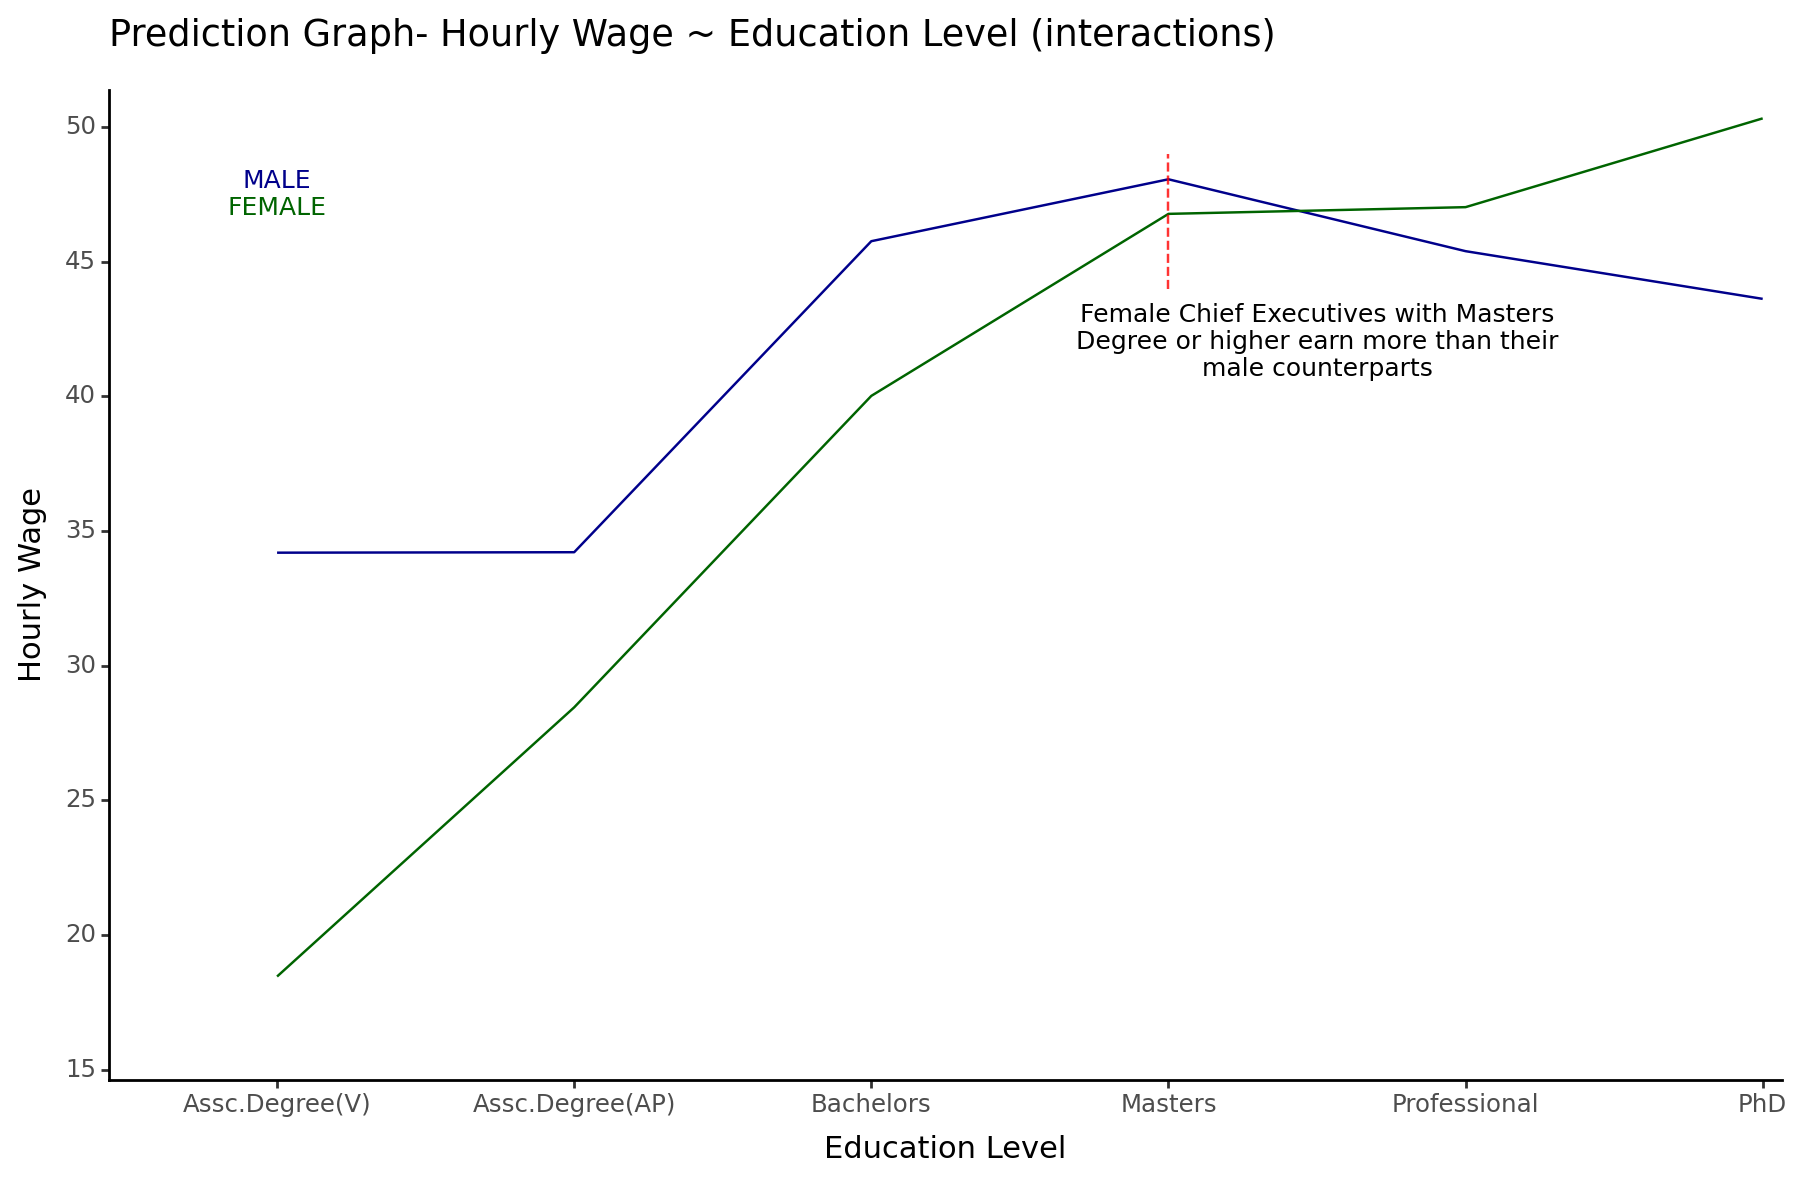

In [43]:
prediction_graph = (
    ggplot()
    + geom_line(data_m, aes(x="grade92", y="fit"), colour="darkblue", show_legend=True)
    + geom_line(data_f, aes(x="grade92", y="fit"), colour="darkgreen", show_legend=True)
    + labs(title='Prediction Graph- Hourly Wage ~ Education Level (interactions)',x="Education Level", y="Hourly Wage")
    + scale_x_continuous(expand=(0.01, 0.01), limits=(40.5, 46), breaks=range(41, 47), 
                         labels=['Assc.Degree(V)', 'Assc.Degree(AP)', 'Bachelors', 'Masters', 'Professional', 'PhD'])
    + scale_y_continuous(expand=(0.01, 0.01), limits=(15,51), breaks=range(15,55,5))
    + theme_classic()
    + theme(figure_size=(9, 6))
    + geom_segment(aes(x=44, xend=44, y=44, yend=49),linetype='dashed',size=0.5,alpha=0.8,color='red')
    + annotate("text", x=44.5, y=43, label="Female Chief Executives with Masters",size=9, color='black')
    + annotate("text", x=44.5, y=42, label="Degree or higher earn more than their",size=9, color='black')
    + annotate("text", x=44.5, y=41, label="male counterparts",size=9, color='black')
    + annotate("text", x=41, y=48, label="MALE",size=9, color='darkblue')
    + annotate("text", x=41, y=47, label="FEMALE",size=9, color='darkgreen')
                    )

prediction_graph.draw()